## High percentile precipitation rate - all models + obs

extremes for the domain as a whole (high percentile daily precipitation rate) averaged over a time period

In [2]:
import xarray as xr
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
from matplotlib import cm
import cartopy.crs as ccrs
import cartopy.feature as cfeat
import seaborn as sns

from os.path import expanduser
home = expanduser("~")


import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [3]:
models = [
    'IPSL-CM5A-MR', # 1
    'GFDL-CM3',     # 2
    'GISS-E2-H',    # 3
    'bcc-csm1-1',   # 4
    'CNRM-CM5',     # 5
    # 'CCSM4',        # 6 # cannot concatanate files for rcp85 run
    'HadGEM2-AO',   # 7
    'BNU-ESM',      # 8
    'EC-EARTH',     # 9
    'FGOALS-g2',    # 10
    'MPI-ESM-MR',   # 11
    'CMCC-CM',      # 12
    'inmcm4',       # 13
    'NorESM1-M',    # 14
    'CanESM2',      # 15
    'MIROC5',       # 16
    'HadGEM2-CC',   # 17
    'MRI-CGCM3',    # 18
    'CESM1-BGC'     # 19
    ]
model = models[0]

experiments = [
    'historical',
    # 'rcp85'
    ]
experiment = experiments[0]


obs = {'GPCP':True}

percentile_options = [
    # 'pr95',
    # 'pr97',
    'pr99',
    # 'pr999',
    ]
percentile_option = percentile_options[0]


## climatology

### time mean

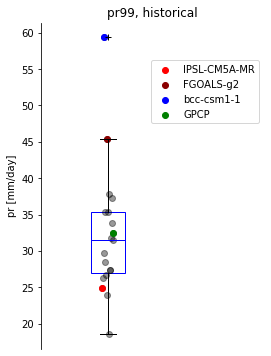

In [6]:
y= []
for model in models:
    folder = home + '/Documents/data/cmip5/' + model
    fileName = model + '_pr_percentiles_' + experiment + '.nc'
    path = folder + '/' + fileName
    ds = xr.open_dataset(path)
    y = np.append(y, ds[percentile_option].mean(dim='time'))


if obs['GPCP']:
    folder = home + '/Documents/data/obs/GPCP'
    fileName = 'GPCP_pr_percentiles.nc'
    path = folder + '/' + fileName
    ds = xr.open_dataset(path)
    y = np.append(y, ds[percentile_option].mean(dim='time'))


plt.figure(figsize=(4,6))
plt.xlim(0,1)
# plt.ylim(16,28)

plt.boxplot(y,vert=True, positions= [0.3], patch_artist=True, medianprops = dict(color="b",linewidth=1),boxprops = dict(color="b",facecolor='w',zorder=0)
            ,sym='+',flierprops = dict(color="r"))


x = np.linspace(0.3-0.025, 0.3+0.025, len(y))
plt.scatter(x, y, c='k', alpha=0.4)
#plt.scatter(np.ones(len(y)), y)


x_leg = [models.index('IPSL-CM5A-MR'),models.index('FGOALS-g2'), models.index('bcc-csm1-1'), -1]
label = ['IPSL-CM5A-MR','FGOALS-g2','bcc-csm1-1', 'GPCP']
colors = ['r','darkred','b', 'g']
j=0
for i in x_leg:
    plt.scatter(x[i],y[i],c=colors[j], label=label[j])
    j+=1


plt.xticks([])
plt.title(percentile_option + ', ' + experiment)
plt.ylabel('pr [mm/day]')
plt.legend(bbox_to_anchor=(0.6,0.5,0.4,0.4))

sns.despine(top=True, right=True, left=False, bottom=True)

### annual

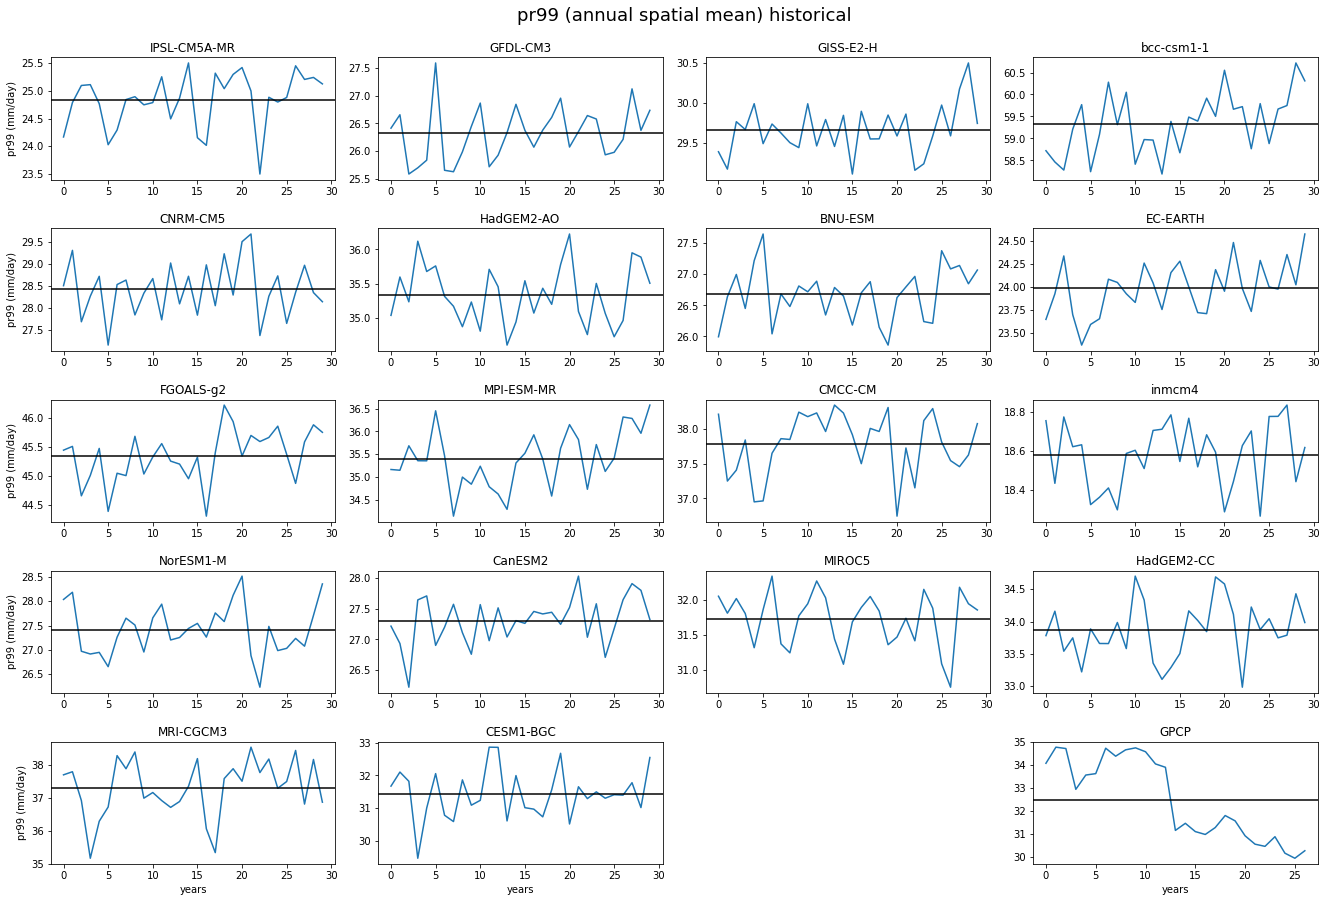

In [37]:
f, axes = plt.subplots(nrows=5, ncols=4, figsize = (22,14))
f.suptitle(percentile_option + ' (annual spatial mean) ' + experiment, fontsize=18, y=0.95)

for model, ax in zip(models, axes.ravel()):

    folder = home + '/Documents/data/cmip5/' + model
    fileName = model + '_pr_percentiles_' + experiment + '.nc'
    path = folder + '/' + fileName
    ds = xr.open_dataset(path)

    ax.plot(ds[percentile_option].resample(time='Y').mean(dim='time'))
    ax.axhline(y=ds[percentile_option].resample(time='Y').mean(dim='time').mean(dim='time'), color='k')
    ax.set_title(model)

    if model == 'MRI-CGCM3' or model == 'CESM1-BGC':
        ax.set_xlabel('years')

    if model == 'IPSL-CM5A-MR' or model == 'CNRM-CM5' or model == 'FGOALS-g2' or model == 'NorESM1-M' or model == 'MRI-CGCM3': 
        ax.set_ylabel(percentile_option + ' (mm/day)')


if obs['GPCP']:
    ax = axes[-1,-1]
    folder = home + '/Documents/data/obs/GPCP'
    fileName = 'GPCP_pr_percentiles.nc'
    path = folder + '/' + fileName
    ds = xr.open_dataset(path)
    ax.plot(ds[percentile_option].resample(time='Y').mean(dim='time'))
    ax.axhline(y=ds[percentile_option].resample(time='Y').mean(dim='time').mean(dim='time'), color='k')
    ax.set_title('GPCP')
    ax.set_xlabel('years')
    

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.15, hspace=0.4)
axes[-1, 2].remove()

### seasonally

In [13]:
def to_monthly(da):
    year = da.time.dt.year
    month = da.time.dt.month

    # assign new coords
    da = da.assign_coords(year=("time", year.data), month=("time", month.data))

    # reshape the array to (..., "month", "year")
    return da.set_index(time=("year", "month")).unstack("time")

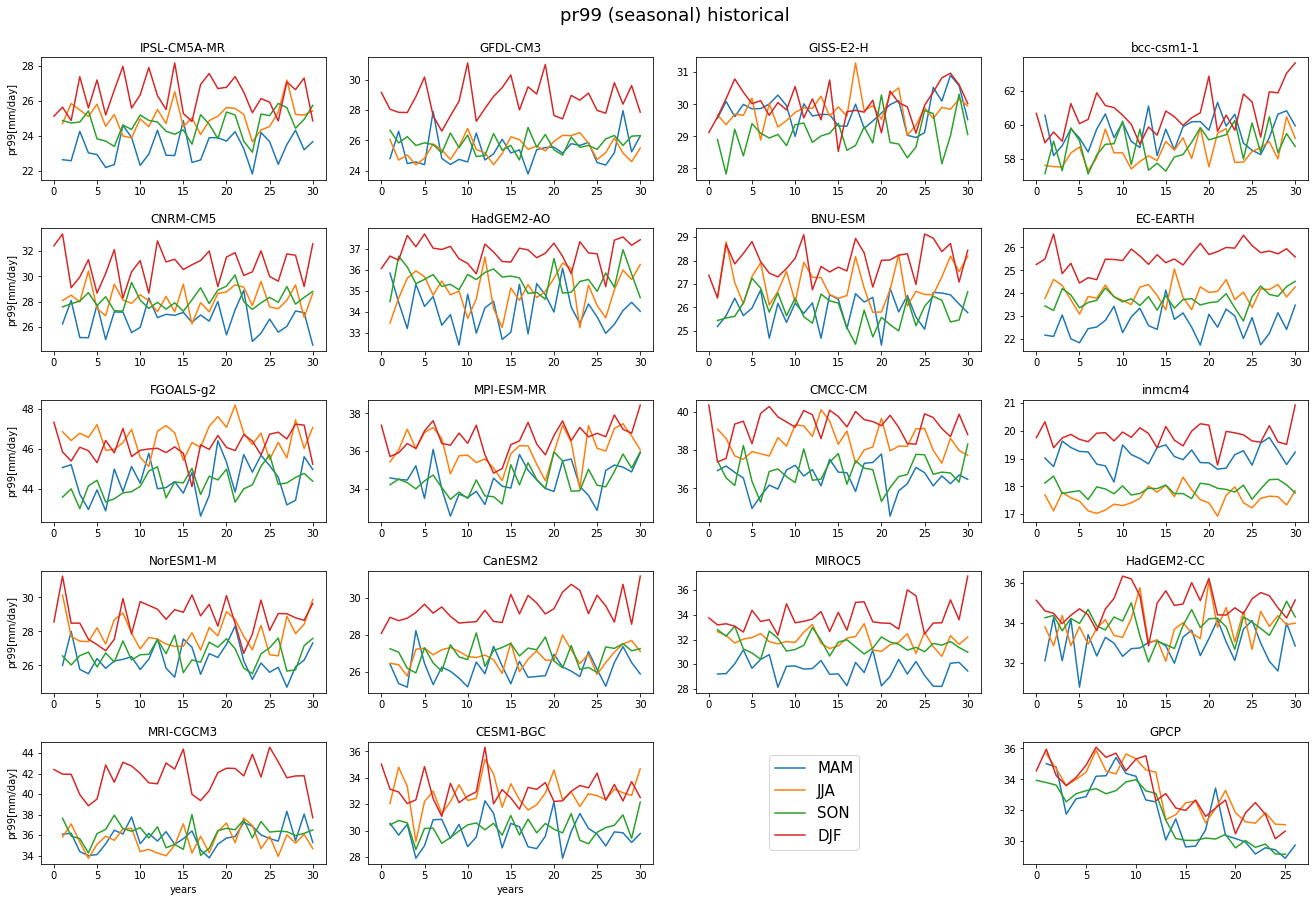

In [36]:
f, axes = plt.subplots(nrows=5, ncols=4, figsize = (22,14))
f.suptitle(percentile_option + ' (seasonal) ' + experiment, fontsize=18, y=0.95)

for model, ax in zip(models, axes.ravel()):

    folder = home + '/Documents/data/cmip5/' + model
    fileName = model + '_pr_percentiles_' + experiment + '.nc'
    path = folder + '/' + fileName
    ds = xr.open_dataset(path)

    pr_season = ds[percentile_option].resample(time='QS-DEC').mean(dim="time")
    pr_season = to_monthly(pr_season)
    pr_season = pr_season.rename({'month':'season'})
    pr_season = pr_season.assign_coords(season = ["MAM", "JJA", "SON", "DJF"])

    ax.plot(pr_season, label = pr_season.season.values)
    ax.set_title(model)
    # ax.legend()

    if model == 'MRI-CGCM3' or model == 'CESM1-BGC':
        ax.set_xlabel('years')

    if model == 'IPSL-CM5A-MR' or model == 'CNRM-CM5' or model == 'FGOALS-g2' or model == 'NorESM1-M' or model == 'MRI-CGCM3': 
        ax.set_ylabel(percentile_option + '[mm/day]')


if obs['GPCP']:
    ax = axes[-1,-1]
    folder = home + '/Documents/data/obs/GPCP'
    fileName = 'GPCP_pr_percentiles.nc'
    path = folder + '/' + fileName
    ds = xr.open_dataset(path)
    
    pr_season = ds[percentile_option].resample(time='QS-DEC').mean(dim="time")
    pr_season = to_monthly(pr_season)
    pr_season = pr_season.rename({'month':'season'})
    pr_season = pr_season.assign_coords(season = ["MAM", "JJA", "SON", "DJF"])

    ax.plot(pr_season, label = pr_season.season.values)
    ax.set_title('GPCP')
    ax.legend(bbox_to_anchor=(-0.55, 0.95), fontsize=15)


plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.15, hspace=0.4)
axes[-1, 2].remove()

### monthly

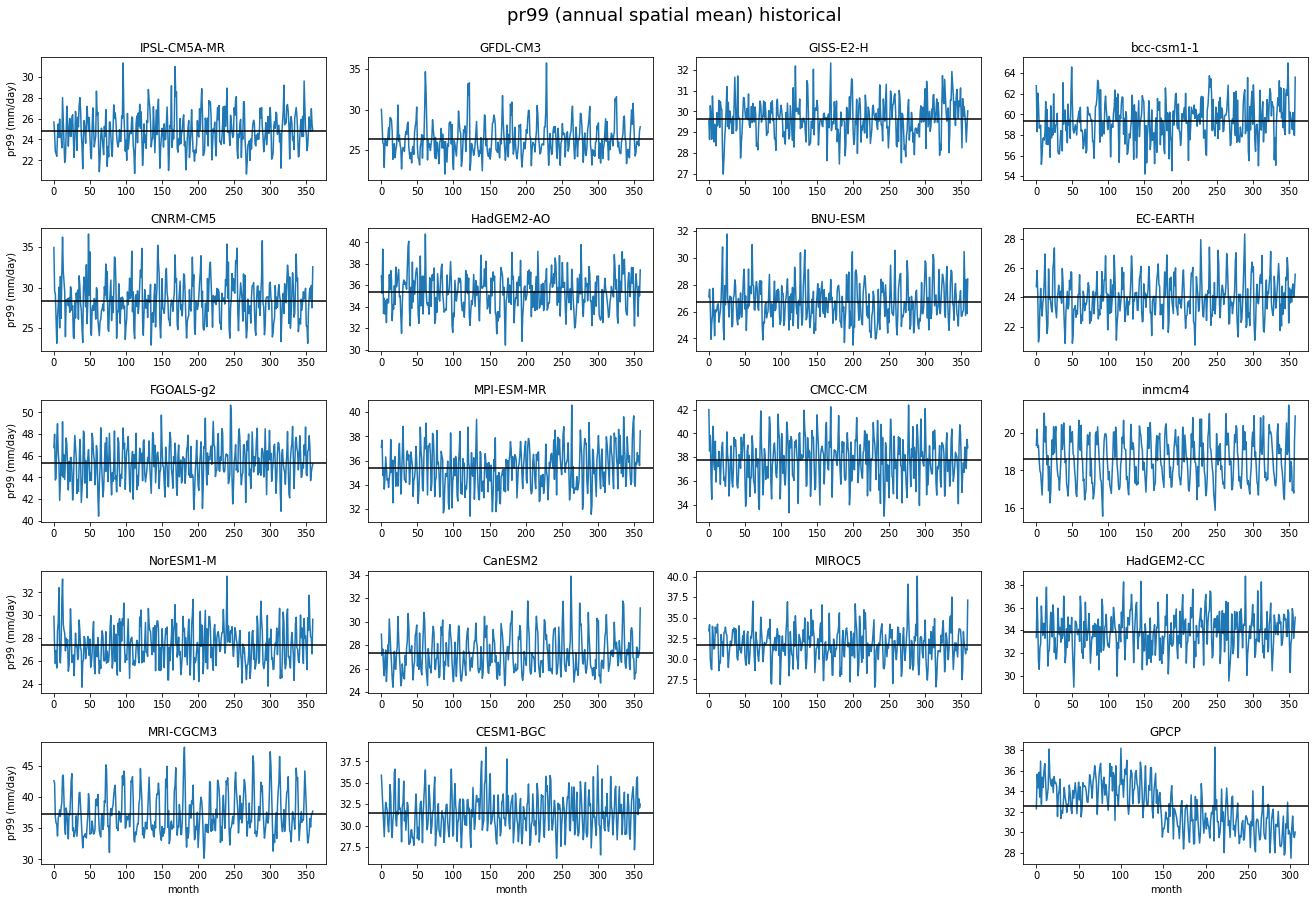

In [38]:
f, axes = plt.subplots(nrows=5, ncols=4, figsize = (22,14))
f.suptitle(percentile_option + ' (annual spatial mean) ' + experiment, fontsize=18, y=0.95)

for model, ax in zip(models, axes.ravel()):

    folder = home + '/Documents/data/cmip5/' + model
    fileName = model + '_pr_percentiles_' + experiment + '.nc'
    path = folder + '/' + fileName
    ds = xr.open_dataset(path)

    ax.plot(ds[percentile_option].resample(time='M').mean(dim='time'))
    ax.axhline(y=ds[percentile_option].resample(time='M').mean(dim='time').mean(dim='time'), color='k')
    ax.set_title(model)

    if model == 'MRI-CGCM3' or model == 'CESM1-BGC':
        ax.set_xlabel('month')

    if model == 'IPSL-CM5A-MR' or model == 'CNRM-CM5' or model == 'FGOALS-g2' or model == 'NorESM1-M' or model == 'MRI-CGCM3': 
        ax.set_ylabel(percentile_option + ' (mm/day)')


if obs['GPCP']:
    ax = axes[-1,-1]
    folder = home + '/Documents/data/obs/GPCP'
    fileName = 'GPCP_pr_percentiles.nc'
    path = folder + '/' + fileName
    ds = xr.open_dataset(path)
    ax.plot(ds[percentile_option].resample(time='M').mean(dim='time'))
    ax.axhline(y=ds[percentile_option].resample(time='M').mean(dim='time').mean(dim='time'), color='k')
    ax.set_title('GPCP')
    ax.set_xlabel('month')
    

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.15, hspace=0.4)
axes[-1, 2].remove()

### daily

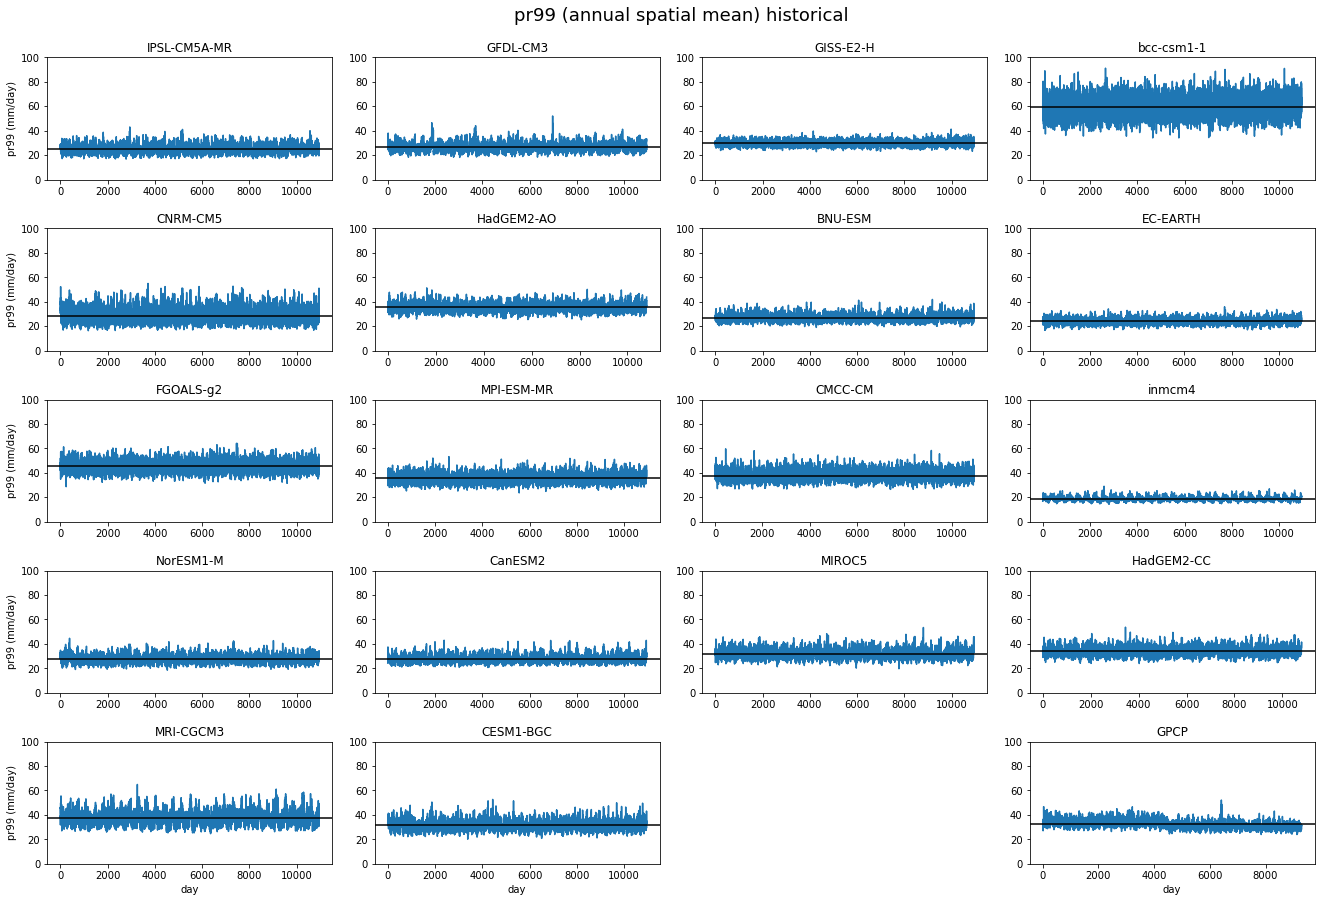

In [43]:
f, axes = plt.subplots(nrows=5, ncols=4, figsize = (22,14))
f.suptitle(percentile_option + ' (annual spatial mean) ' + experiment, fontsize=18, y=0.95)

for model, ax in zip(models, axes.ravel()):

    folder = home + '/Documents/data/cmip5/' + model
    fileName = model + '_pr_percentiles_' + experiment + '.nc'
    path = folder + '/' + fileName
    ds = xr.open_dataset(path)

    ax.plot(ds[percentile_option])
    ax.axhline(y=ds[percentile_option].mean(dim='time'), color='k')
    ax.set_title(model)
    ax.set_ylim([0,100])

    if model == 'MRI-CGCM3' or model == 'CESM1-BGC':
        ax.set_xlabel('day')

    if model == 'IPSL-CM5A-MR' or model == 'CNRM-CM5' or model == 'FGOALS-g2' or model == 'NorESM1-M' or model == 'MRI-CGCM3': 
        ax.set_ylabel(percentile_option + ' (mm/day)')


if obs['GPCP']:
    ax = axes[-1,-1]
    folder = home + '/Documents/data/obs/GPCP'
    fileName = 'GPCP_pr_percentiles.nc'
    path = folder + '/' + fileName
    ds = xr.open_dataset(path)
    ax.plot(ds[percentile_option])
    ax.axhline(y=ds[percentile_option].mean(dim='time'), color='k')
    ax.set_title('GPCP')
    ax.set_xlabel('days')
    ax.set_ylim([0,100])

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.15, hspace=0.4)
axes[-1, 2].remove()

## change with warming

In [44]:
folder = home + '/Documents/data/cmip5/' + model
fileName = model + '_pr_percentiles_historical.nc'
path = folder + '/' + fileName
ds = xr.open_dataset(path)
percentile_historical = ds[percentile_option].mean(dim='time')

In [47]:
folder = home + '/Documents/data/cmip5/' + model
fileName = model + '_pr_percentiles_rcp85.nc'
path = folder + '/' + fileName
ds = xr.open_dataset(path)
percentile_rcp = ds[percentile_option].mean(dim='time')

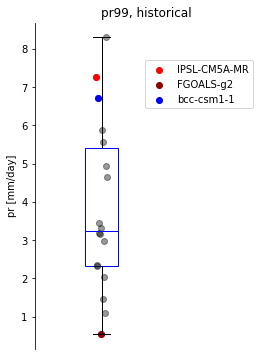

In [50]:
y= []
for model in models:
    folder = home + '/Documents/data/cmip5/' + model
    fileName = model + '_pr_percentiles_historical.nc'
    path = folder + '/' + fileName
    ds = xr.open_dataset(path)
    percentile_historical = ds[percentile_option].mean(dim='time')


    folder = home + '/Documents/data/cmip5/' + model
    fileName = model + '_pr_percentiles_rcp85.nc'
    path = folder + '/' + fileName
    ds = xr.open_dataset(path)
    percentile_rcp = ds[percentile_option].mean(dim='time')

    y = np.append(y, (percentile_rcp - percentile_historical))


plt.figure(figsize=(4,6))
plt.xlim(0,1)
# plt.ylim(16,28)

plt.boxplot(y,vert=True, positions= [0.3], patch_artist=True, medianprops = dict(color="b",linewidth=1),boxprops = dict(color="b",facecolor='w',zorder=0)
            ,sym='+',flierprops = dict(color="r"))


x = np.linspace(0.3-0.025, 0.3+0.025, len(y))
plt.scatter(x, y, c='k', alpha=0.4)
#plt.scatter(np.ones(len(y)), y)


x_leg = [models.index('IPSL-CM5A-MR'),models.index('FGOALS-g2'), models.index('bcc-csm1-1')]
label = ['IPSL-CM5A-MR','FGOALS-g2','bcc-csm1-1', 'GPCP']
colors = ['r','darkred','b']
j=0
for i in x_leg:
    plt.scatter(x[i],y[i],c=colors[j], label=label[j])
    j+=1


plt.xticks([])
plt.title(percentile_option + ', ' + experiment)
plt.ylabel('pr [mm/day]')
plt.legend(bbox_to_anchor=(0.6,0.5,0.4,0.4))

sns.despine(top=True, right=True, left=False, bottom=True)

## other

### monthly mean

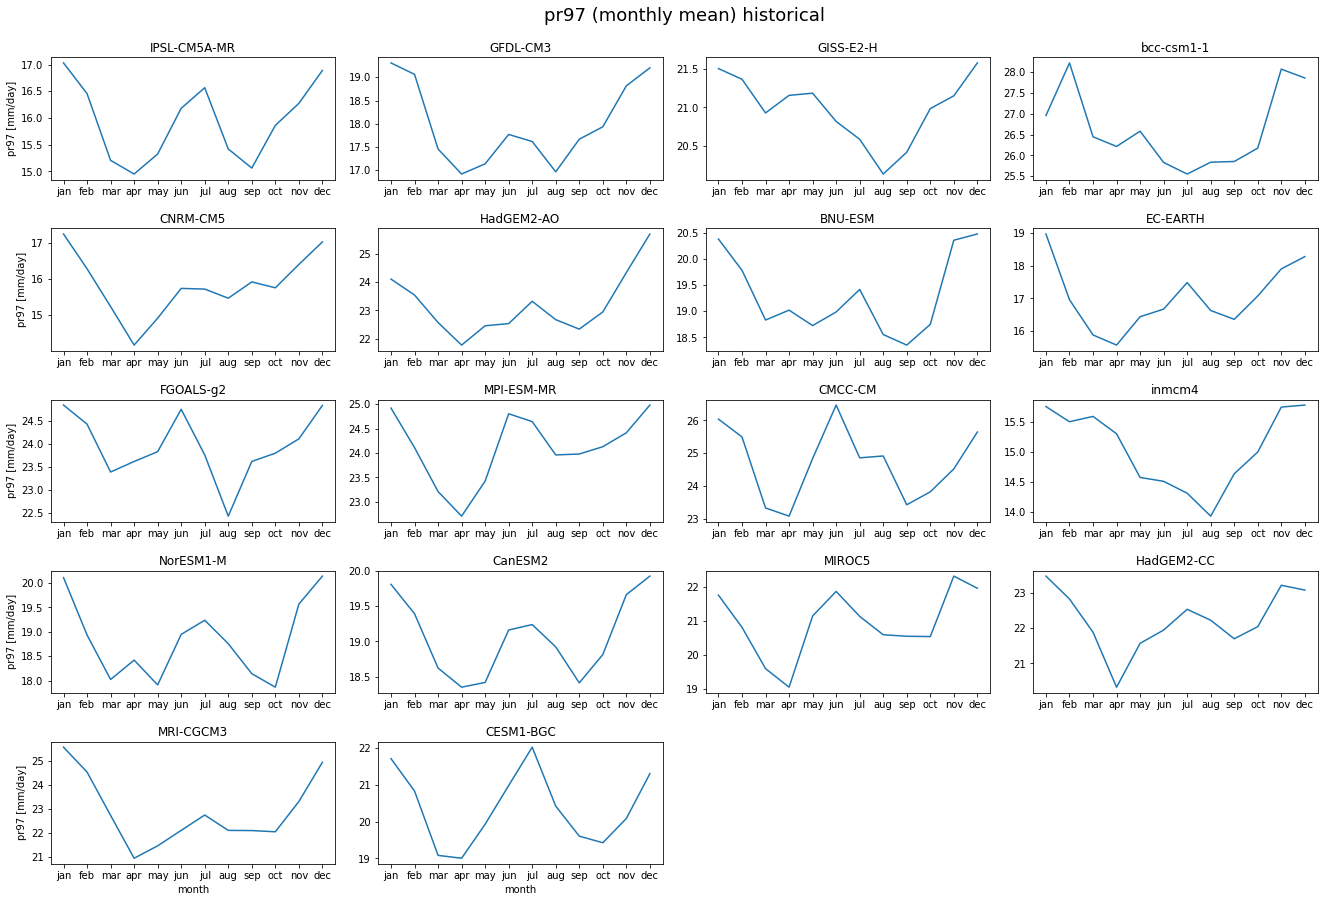

In [ ]:
f, axes = plt.subplots(nrows=5, ncols=4, figsize = (22,14))
f.suptitle(percentile_option + ' (monthly mean) ' + experiment, fontsize=18, y=0.95)

for model, ax in zip(models, axes.ravel()):
    if switch['local_files']:
        folder = home + '/Documents/data/cmip5/' + model

    if switch['nci_files']:
        folder = '/g/data/k10/cb4968/data/cmip5/'+ model

    fileName = model + '_pr_percentiles_' + experiment + '.nc'
    path = folder + '/' + fileName
    pr_percentiles= xr.open_dataset(path)

    pr_monthly = to_monthly(pr_percentiles[percentile_option])
    pr_monthly = pr_monthly.assign_coords(month = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul','aug', 'sep', 'oct', 'nov', 'dec'])

    ax.plot(pr_monthly.mean(dim='year'))
    ax.set_title(model)
    ax.set_xticks(np.arange(0,12))
    ax.set_xticklabels(pr_monthly.month.values)

    if model == 'MRI-CGCM3' or model == 'CESM1-BGC':
        ax.set_xlabel('month')

    if model == 'IPSL-CM5A-MR' or model == 'CNRM-CM5' or model == 'FGOALS-g2' or model == 'NorESM1-M' or model == 'MRI-CGCM3': 
        ax.set_ylabel(percentile_option + ' [mm/day]')

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.15, hspace=0.4)
axes[-1, 2].remove()
axes[-1, 3].remove()